In [1]:
import lifelines
import pymc as pm
import pyBMA
import matplotlib.pyplot as plt
import numpy as np
from math import log
from datetime import datetime
import pandas as pd
%matplotlib inline  

The first step in any data analysis is acquiring and munging the data

An example data set can be found at:
   https://jakecoltman.gitlab.io/website/post/pydata/

Download the file output.txt and transform it into a format like below where the event column should be 0 if there's only one entry for an id, and 1 if there are two entries:

End date = datetime.datetime(2016, 5, 3, 20, 36, 8, 92165)

id,time_to_convert,age,male,event,search,brand

In [10]:
running_id = 0
output = [[0]]
with open("E:/output.txt") as file_open:
    for row in file_open.read().split("\n"):
        cols = row.split(",")
        if cols[0] == output[-1][0]:
            output[-1].append(cols[1])
            output[-1].append(True)
        else:
            output.append(cols)
    output = output[1:]
    
for row in output:
    if len(row) == 6:
        row += [datetime(2016, 5, 3, 20, 36, 8, 92165), False]
output = output[1:-1]

In [13]:
def convert_to_days(dt):
    day_diff = dt / np.timedelta64(1, 'D')
    if day_diff == 0:
        return 23.0
    else: 
        return day_diff

df = pd.DataFrame(output, columns=["id", "advert_time", "male","age","search","brand","conversion_time","event"])
df["lifetime"] = pd.to_datetime(df["conversion_time"]) - pd.to_datetime(df["advert_time"])
df["lifetime"] = df["lifetime"].apply(convert_to_days)
df["male"] = df["male"].astype(int)
df["search"] = df["search"].astype(int)
df["brand"] = df["brand"].astype(int)
df["age"] = df["age"].astype(int)
df["event"] = df["event"].astype(int)
df = df.drop('advert_time', 1)
df = df.drop('conversion_time', 1)
df = df.set_index("id")
df = df.dropna(thresh=2)
df.median()
df

,male,age,search,brand,event,lifetime
id,,,,,,
1,0,59,1,1,0,18.358052
2,0,41,0,0,0,19.613458
3,0,56,0,1,1,10.007883
4,0,47,0,0,1,11.601139
5,1,44,1,0,1,11.815086
6,1,29,1,0,0,21.031488
7,0,22,0,0,1,13.039954
8,0,23,0,1,1,8.593106
9,1,19,0,0,1,1.965708


In [ ]:
###Parametric Bayes
#Shout out to Cam Davidson-Pilon

In [16]:
## Example fully worked model using toy data
## Adapted from http://blog.yhat.com/posts/estimating-user-lifetimes-with-pymc.html
## Note that we've made some corrections
censor = np.array(df["event"].apply(lambda x: 0 if x else 1).tolist())
alpha = pm.Uniform("alpha", 0,50) 
beta = pm.Uniform("beta", 0,50) 

@pm.observed
def survival(value=df["lifetime"], alpha = alpha, beta = beta ):
    return sum( (1-censor)*(np.log( alpha/beta) + (alpha-1)*np.log(value/beta)) - (value/beta)**(alpha))


mcmc = pm.MCMC([alpha, beta, survival ] )
mcmc.sample(10000)

 [-----------------100%-----------------] 10000 of 10000 complete in 24.9 sec

Plotting alpha
Plotting beta


array([ 8.97671912,  8.97671912,  8.97671912, ...,  1.79408852,
        1.79408852,  1.79408852])

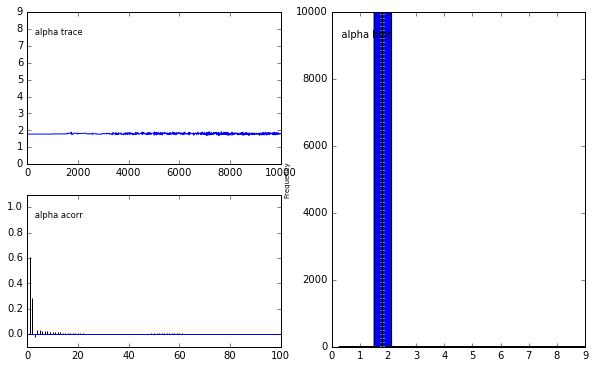

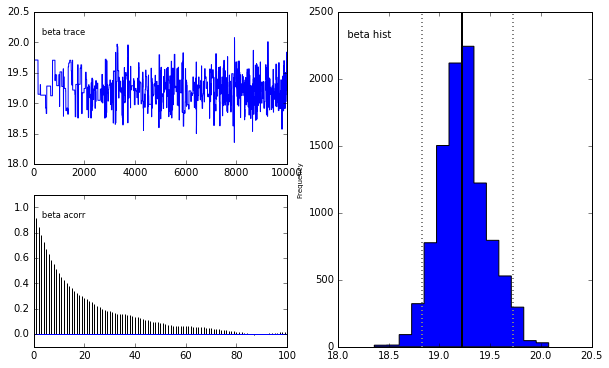

In [17]:
pm.Matplot.plot(mcmc)
mcmc.trace("alpha")[:]

Problems: 

    2 - Try to fit your data from section 1 
    3 - Use the results to plot the distribution of the median
    --------
    4 - Try adjusting the number of samples, the burn parameter and the amount of thinning to correct get good answers
    5 - Try adjusting the prior and see how it affects the estimate
    --------
    6 - Try to fit a different distribution to the data
    7 - Compare answers
    Bonus - test the hypothesis that the true median is greater than a certain amount
    
For question 2, note that the median of a Weibull is:

$$β(log 2)^{1/α}$$
    

(array([  1.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   9.81600000e+03,   1.80000000e+02,
          3.00000000e+00]),
 array([  4.88512654,   6.28886044,   7.69259433,   9.09632823,
         10.50006213,  11.90379603,  13.30752992,  14.71126382,
         16.11499772,  17.51873162,  18.92246552]),
 <a list of 10 Patch objects>)

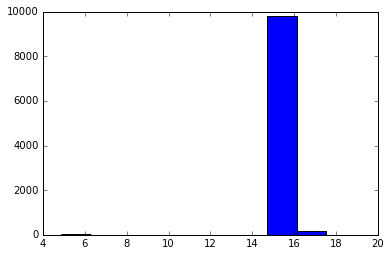

In [18]:
#Solution to question 4:
def weibull_median(alpha, beta):
    return beta * ((log(2)) ** ( 1 / alpha))
plt.hist([weibull_median(x[0], x[1]) for x in zip(mcmc.trace("alpha"), mcmc.trace("beta"))])

 [-----------------100%-----------------] 10000 of 10000 complete in 22.0 secPlotting alpha
Plotting beta


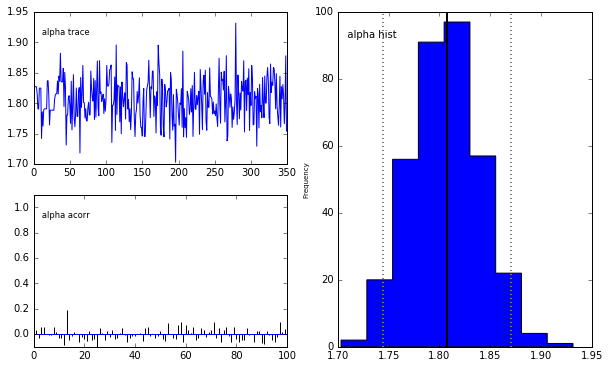

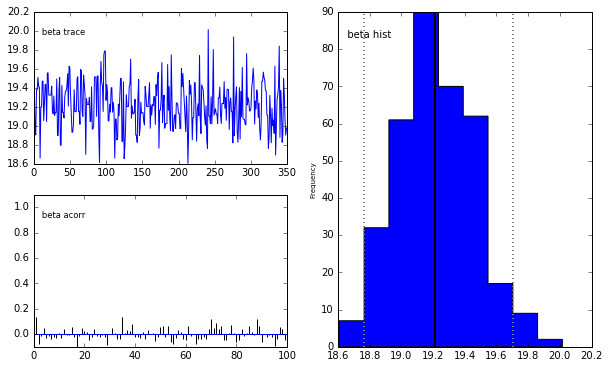

In [20]:
#Solution to question 4:
### Increasing the burn parameter allows us to discard results before convergence
### Thinning the results removes autocorrelation

mcmc = pm.MCMC([alpha, beta, survival ] )
mcmc.sample(10000, burn = 3000, thin = 20)

pm.Matplot.plot(mcmc)

 [-----------------100%-----------------] 10000 of 10000 complete in 18.7 secPlotting alpha
Plotting beta


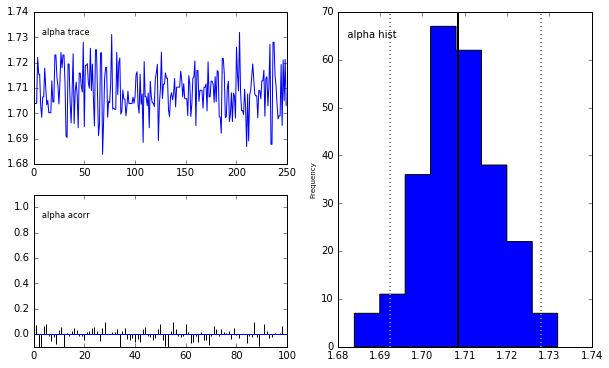

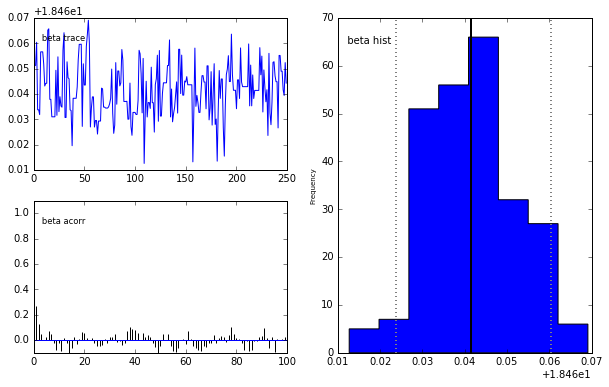

In [22]:
#Solution to Q5
## Adjusting the priors impacts the overall result
## If we give a looser, less informative prior then we end up with a broader, shorter distribution
## If we give much more informative priors, then we get a tighter, taller distribution

censor = np.array(df["event"].apply(lambda x: 0 if x else 1).tolist())

## Note the narrowing of the prior
alpha = pm.Normal("alpha", 1.7, 10000) 
beta = pm.Normal("beta", 18.5, 10000) 

####Uncomment this to see the result of looser priors
## Note this ends up pretty much the same as we're already very loose
#alpha = pm.Uniform("alpha", 0, 30) 
#beta = pm.Uniform("beta", 0, 30) 

@pm.observed
def survival(value=df["lifetime"], alpha = alpha, beta = beta ):
    return sum( (1-censor)*(np.log( alpha/beta) + (alpha-1)*np.log(value/beta)) - (value/beta)**(alpha))

mcmc = pm.MCMC([alpha, beta, survival ] )
mcmc.sample(10000, burn = 5000, thin = 20)
pm.Matplot.plot(mcmc)
#plt.hist([weibull_median(x[0], x[1]) for x in zip(mcmc.trace("alpha"), mcmc.trace("beta"))])

In [143]:
## Solution to bonus
## Super easy to do in the Bayesian framework, all we need to do is look at what % of samples
## meet our criteria
medians = [weibull_median(x[0], x[1]) for x in zip(mcmc.trace("alpha"), mcmc.trace("beta"))]
testing_value = 15.6
number_of_greater_samples = sum([x >= testing_value for x in medians])
100 * (number_of_greater_samples / len(medians))

64.0

In [ ]:
#Cox model

If we want to look at covariates, we need a new approach.  We'll use Cox proprtional hazards.  More information here.

In [23]:
#Fitting solution
cf = lifelines.CoxPHFitter()
cf.fit(df, 'lifetime', event_col = 'event')
cf.summary

C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


,coef,exp(coef),se(coef),z,p,lower 0.95,upper 0.95
male,0.918199,2.504776,0.023830,38.531786,0.000000,0.871484,0.964915
age,-0.007011,0.993013,0.022145,-0.316614,0.751537,-0.050425,0.036402
search,-1.051111,0.349549,0.024398,-43.082327,0.000000,-1.098940,-1.003281
brand,0.011492,1.011558,0.022047,0.521233,0.602204,-0.031730,0.054713


Once we've fit the data, we need to do something useful with it.  Try to do the following things:

    1 - Plot the baseline survival function

    2 - Predict the functions for a particular set of features

    3 - Plot the survival function for two different set of features

    4 - For your results in part 3 caculate how much more likely a death event is for one than the other for a given period of time

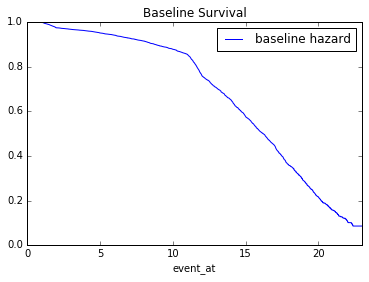

In [24]:
#Solution to 1
fig, axis = plt.subplots(nrows=1, ncols=1)
cf.baseline_survival_.plot(ax = axis, title = "Baseline Survival")

In [26]:
# Solution to prediction
regressors = np.array([[1,45,0,0]])
survival = cf.predict_survival_function(regressors)
survival

,0
event_at,
0.000000,1.000000e+00
1.007159,9.986030e-01
1.011755,9.972059e-01
1.026149,9.958088e-01
1.032037,9.944117e-01
1.032459,9.930145e-01
1.035578,9.916174e-01
1.046138,9.902203e-01
1.048734,9.888231e-01


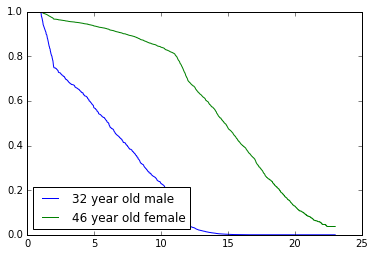

In [32]:
#Solution to plotting multiple regressors
fig, axis = plt.subplots(nrows=1, ncols=1, sharex=True)
regressor1 = np.array([[1,45,0,1]])
regressor2 = np.array([[1,23,1,1]])
survival_1 = cf.predict_survival_function(regressor1)
survival_2 = cf.predict_survival_function(regressor2)
plt.plot(survival_1,label = "32 year old male")
plt.plot(survival_2,label = "46 year old female")
plt.legend(loc = "lower left")

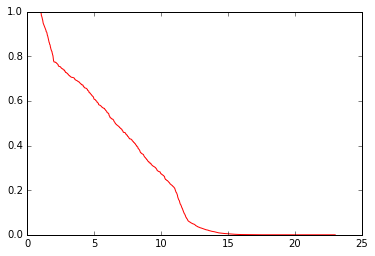

In [34]:
#Difference in survival 
odds = survival_1 / survival_2
plt.plot(odds, c = "red")

Model selection

Difficult to do with classic tools (here)

Problem:

    1 - Calculate the BMA coefficient values

    2 - Compare these results to past the lifelines results
    
    3 - Try running with different priors

In [40]:

##Solution to 1
from pyBMA import CoxPHFitter
bmaCox = pyBMA.CoxPHFitter.CoxPHFitter()
bmaCox.fit(df, "lifetime", event_col= "event", priors= [0.5]*4)

C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


In [41]:
print(bmaCox.summary)

            coef  exp(coef)
age    -0.000122   0.999878
brand   0.000225   1.000225
male    0.917887   2.503993
search -1.050679   0.349700


In [42]:
#Low probability for everything favours parsimonious models
bmaCox = pyBMA.CoxPHFitter.CoxPHFitter()
bmaCox.fit(df, "lifetime", event_col= "event", priors= [0.1]*4)
print(bmaCox.summary)

C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)


In [43]:
#Low probability for everything favours parsimonious models
bmaCox = pyBMA.CoxPHFitter.CoxPHFitter()
bmaCox.fit(df, "lifetime", event_col= "event", priors= [0.9]*4)
print(bmaCox.summary)

            coef  exp(coef)
age    -0.000014   0.999986
brand   0.000026   1.000026
male    0.917881   2.503978
search -1.050672   0.349703


In [45]:
#Low probability for everything favours parsimonious models
bmaCox = pyBMA.CoxPHFitter.CoxPHFitter()
bmaCox.fit(df, "lifetime", event_col= "event", priors= [0.3, 0.9, 0.001, 0.3])
print(bmaCox.summary)

            coef  exp(coef)
age    -0.000967   0.999033
brand   0.000085   1.000085
male    0.917849   2.503900
search -1.050716   0.349687


C:\Users\j.coltman\AppData\Local\Continuum\Anaconda3\lib\site-packages\lifelines\fitters\coxph_fitter.py:285: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  df.sort(duration_col, inplace=True)
